In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

# Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data.dataset import Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Pretrained VGG16 Model

In [2]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the VGG model
vgg16 = VGG()

# Print the model architecture
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
def load_loaders(file_path):
    with open(file_path, 'rb') as file:
        loaders = pickle.load(file)
    return loaders['train_loader'], loaders['val_loader'], loaders['test_loader']

In [4]:
train_loader, valid_loader, test_loader = load_loaders('data_loaders_final.pkl')


In [5]:
# Calculate the size of the subset (10% of the original dataset)
subset_size = int(0.1 * len(train_loader.dataset))
subset_indices = torch.randperm(len(train_loader.dataset))[:subset_size]
# Create a subset using Subset class from torch.utils.data.dataset
subset = Subset(train_loader.dataset, subset_indices)
# Create a new DataLoader for the subset
train_loader_SI = DataLoader(subset, batch_size=train_loader.batch_size, shuffle=True, num_workers=train_loader.num_workers)

In [6]:
# Instantiate and load the model
model = VGG()  
model.load_state_dict(torch.load('best_model_weights.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# calculate SI and CSI for Train - Pretrained Model

In [11]:
# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))

In [12]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 37.72it/s]


In [13]:
si_layer_train =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  si = instance_disturbance.si()
  si_layer_train.append(si)

Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 34529.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36082.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36115.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36178.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36485.47it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36712.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36580.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36759.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36708.80it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36786.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36495.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36547.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36600.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36523.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36690.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36559.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36581.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36497.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36499.25it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36582.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36604.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36534.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36539.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36627.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36563.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36607.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36576.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36580.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36534.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36624.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5000/5000 [00:00<00:00, 36633.52it/s]


In [14]:
print(len(si_layer_train))
print(si_layer_train)

31
[0.1916, 0.1916, 0.1742, 0.1742, 0.2156, 0.24, 0.24, 0.2464, 0.2464, 0.3252, 0.4002, 0.4002, 0.456, 0.456, 0.4406, 0.4406, 0.6146, 0.81, 0.81, 0.9246, 0.9246, 0.9684, 0.9684, 0.9748, 0.9848, 0.9848, 0.9872, 0.9872, 0.9838, 0.9838, 0.9856]


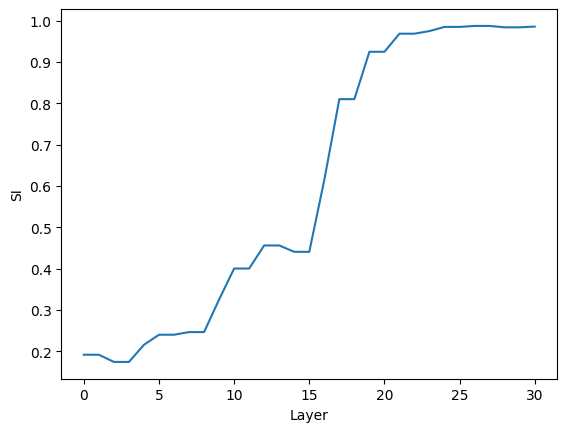

In [15]:
# plot si vs layer for Train
plt.plot(si_layer_train)
plt.xlabel('Layer')
plt.ylabel('SI')
plt.show()

In [16]:
csi_layer_train =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  csi = instance_disturbance.center_si()
  csi_layer_train.append(csi)

Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 541.59it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1893.59it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1923.46it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1906.59it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4869.17it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3287.85it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3295.34it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3319.33it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3305.46it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 6740.00it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4949.62it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4987.87it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5003.94it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4985.50it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4971.32it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5027.94it/s]

Data has been normalized



Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9341.43it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7164.85it/s]

Data has been normalized



Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 6989.34it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 6989.34it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 6956.88it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7280.51it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7121.06it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9670.98it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9370.65it/s]

Data has been normalized



Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 10423.22it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9850.41it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 10031.82it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9118.05it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 9617.76it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 10029.42it/s]


In [18]:
print(csi_layer_train)

[0.3815999925136566, 0.3815999925136566, 0.45419999957084656, 0.45419999957084656, 0.4601999819278717, 0.5435999631881714, 0.5435999631881714, 0.6549999713897705, 0.6549999713897705, 0.6353999972343445, 0.6827999949455261, 0.6827999949455261, 0.7360000014305115, 0.7360000014305115, 0.8381999731063843, 0.8381999731063843, 0.8319999575614929, 0.8797999620437622, 0.8797999620437622, 0.9283999800682068, 0.9283999800682068, 0.9567999839782715, 0.9567999839782715, 0.9648000001907349, 0.9833999872207642, 0.9833999872207642, 0.986799955368042, 0.986799955368042, 0.9871999621391296, 0.9871999621391296, 0.9865999817848206]


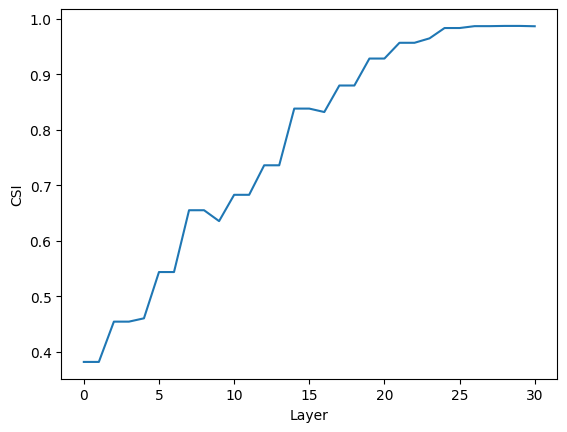

In [19]:
# plot si vs layer for Train
plt.plot(csi_layer_train)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# calculate SI and CSI for Test - Pretrained Model

In [8]:
# Prepare storage for outputs and labels
features_per_layer = [[] for _ in range(len(model.features))]
labels_list = []

# Function to attach hooks
def get_layer_outputs(layer_idx):
    def hook(module, input, output):
        features_per_layer[layer_idx].append(output.detach())
    return hook

# Attach hooks to each layer
for idx, layer in enumerate(model.features):
    layer.register_forward_hook(get_layer_outputs(idx))
    
    
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets)

        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for idx, layer_features in enumerate(features_per_layer):
    layer_features = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    features_per_layer[idx] = layer_features

labels = torch.cat(labels_list)    

100%|██████████| 71/71 [00:01<00:00, 47.03it/s]


In [10]:
si_layer_test =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  si = instance_disturbance.si()
  si_layer_test.append(si)

Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34378.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33936.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 37070.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32439.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32047.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34356.95it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33763.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34188.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34484.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34059.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34451.24it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 35229.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32091.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34904.86it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33154.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32606.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32966.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34229.72it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32617.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33472.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34486.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33711.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 32714.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33513.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34144.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33970.07it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 34375.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 33895.13it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 36030.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 36905.92it/s]


Data has been normalized


Calculating SI: 100%|██████████| 9000/9000 [00:00<00:00, 36828.83it/s]


In [11]:
print(len(si_layer_test))
print(si_layer_test)

31
[0.2378888888888889, 0.2378888888888889, 0.2238888888888889, 0.2238888888888889, 0.3055555555555556, 0.333, 0.333, 0.32822222222222225, 0.32822222222222225, 0.4438888888888889, 0.5058888888888889, 0.5058888888888889, 0.5657777777777778, 0.5657777777777778, 0.48644444444444446, 0.48644444444444446, 0.6308888888888889, 0.7812222222222223, 0.7812222222222223, 0.8407777777777777, 0.8407777777777777, 0.8542222222222222, 0.8542222222222222, 0.8562222222222222, 0.8623333333333333, 0.8623333333333333, 0.859, 0.859, 0.8556666666666667, 0.8556666666666667, 0.8616666666666667]


In [13]:
csi_layer_test =[]
for features in features_per_layer:
  instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
  csi = instance_disturbance.center_si()
  csi_layer_test.append(csi)

Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1155.77it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1045.49it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1012.14it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1070.99it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3380.05it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1888.82it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2078.96it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2094.95it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2033.01it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4771.68it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3423.36it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3528.78it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2955.82it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2899.82it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 2983.57it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 3503.43it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 6473.69it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4329.38it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 4889.04it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5192.90it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5063.75it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5143.86it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5048.51it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5818.15it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 8059.77it/s]

Data has been normalized



Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 8164.89it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7714.37it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7918.26it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 7064.69it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 5408.52it/s]


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 8725.41it/s]


In [14]:
print(len(csi_layer_test))
print(csi_layer_test)

31
[0.3921111226081848, 0.3921111226081848, 0.45866668224334717, 0.45866668224334717, 0.49211111664772034, 0.5580000281333923, 0.5580000281333923, 0.6326666474342346, 0.6326666474342346, 0.6334444284439087, 0.6836666464805603, 0.6836666464805603, 0.7304444313049316, 0.7304444313049316, 0.7937777638435364, 0.7937777638435364, 0.7994444370269775, 0.8387777805328369, 0.8387777805328369, 0.8665555715560913, 0.8665555715560913, 0.8795555830001831, 0.8795555830001831, 0.8793333172798157, 0.8948888778686523, 0.8948888778686523, 0.8989999890327454, 0.8989999890327454, 0.8986666798591614, 0.8986666798591614, 0.8985555768013]


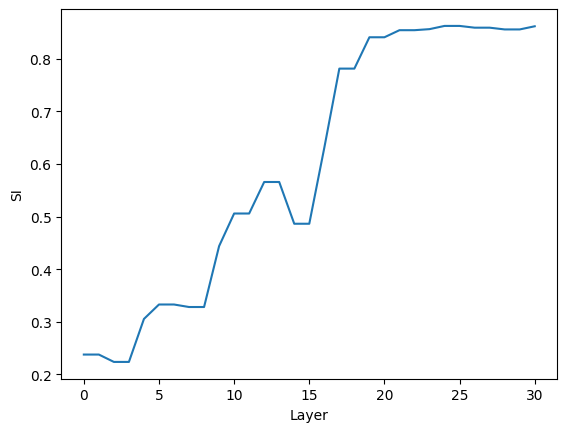

In [18]:
# plot si vs layer for Test
plt.plot(si_layer_test)
plt.xlabel('Layer')
plt.ylabel('SI')
plt.show()

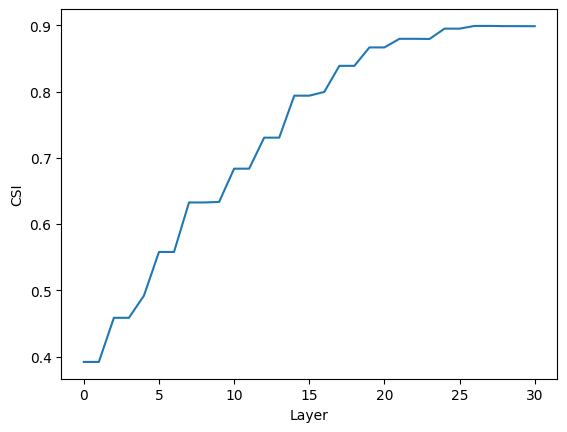

In [19]:
# plot si vs layer for Test
plt.plot(csi_layer_test)
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.show()

# Compress Network

In [7]:
# Redefine the features module up to the (23)
model.features = torch.nn.Sequential(*list(model.features.children())[:24])
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
features = []
labels = []

with torch.no_grad():
    for inputs, targets  in tqdm(train_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')
        # Forward pass through the model.features
        features_batch = model.features(inputs)
        #features_batch = model.avgpool(features_batch)
        features.append(features_batch)
        labels.append(targets)
        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()
        
# Stack and reshape the extracted features
features = torch.cat(features)
features = features.view(features.size(0), -1)
labels = torch.cat(labels)   

labels=labels.unsqueeze(1)  # Make it a 2D tensor

100%|██████████| 40/40 [00:01<00:00, 39.69it/s]


In [9]:
features.size()

torch.Size([5000, 2048])

In [10]:
instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)

Data has been normalized


In [11]:
si_ranked_features, ranked_features = instance_disturbance.forward_feature_ranking_si()

Start forward selection


100%|██████████| 2048/2048 [05:50<00:00,  5.84it/s]


In [ ]:

# # Saving the Ranked Features to .pkl files
# with open('si_ranked_features_new.pkl', 'wb') as f:
#     pickle.dump(si_ranked_features, f)

# with open('ranked_features_new.pkl', 'wb') as f:
#     pickle.dump(ranked_features, f)


In [11]:
# Loading the ranked features from the .pkl files
with open('si_ranked_features_new.pkl', 'rb') as f:
    si_ranked_features = pickle.load(f)

with open('ranked_features_new.pkl', 'rb') as f:
    ranked_features = pickle.load(f)


Ranked features are:  tensor([[1568.,  637., 1271.,  ..., 1743., 1778., 1999.]])
si for the best chosen Features are:  [[0.2836     0.4924     0.6796     ... 0.9722     0.97179997 0.97139996]]


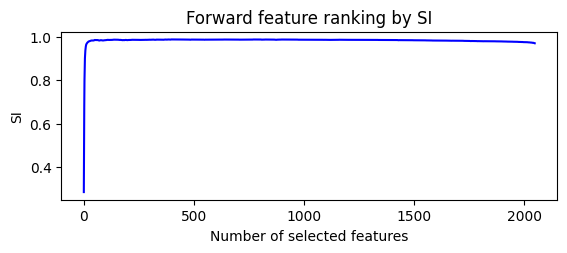

In [12]:
plt.subplot(2, 1, 2)
plt.plot(si_ranked_features.cpu().detach().numpy(), 'b')
plt.xlabel("Number of selected features")
plt.ylabel("SI")
plt.title("Forward feature ranking by SI")
si_ranked_features = torch.transpose(si_ranked_features, 0, 1)
print('Ranked features are: ', ranked_features)
print('si for the best chosen Features are: ', si_ranked_features.detach().cpu().numpy())

In [13]:
ranked_features

tensor([[1568.,  637., 1271.,  ..., 1743., 1778., 1999.]])

In [14]:
np.max(si_ranked_features.detach().cpu().numpy()[0])

0.98939997

In [15]:
si_ranked_features = si_ranked_features.detach().cpu().numpy()[0]
max_index = np.argmax(si_ranked_features)

print("Index of the maximum value:", max_index)

Index of the maximum value: 400


In [16]:
feat = ranked_features[0][:max_index]

In [17]:
feat.size()

torch.Size([400])

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 4096)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(4096, 4096)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(4096, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# class MLPModel(nn.Module):
#     def __init__(self, input_size, output_size, dropout_rate=0.2):
#         super(MLPModel, self).__init__()
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(input_size, output_size)

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.dropout(x)
#         x = self.fc(x)
#         return x

In [19]:
input_size = len(feat)
output_size = 10  
mlp_model = MLPModel(input_size, output_size)

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Move models to device
mlp_model.to(device)
model.to(device)
print("model.feature and MLP loaded to device")

model.feature and MLP loaded to device


In [21]:
# Training and validation loop
num_epochs = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    mlp_model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as tqdm_loader:
        for inputs, labels in tqdm_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get features using the pretrained model
            features_batch = model.features(inputs)
            features_batch = features_batch.view(-1, 2048, 1, 1)
            #features_batch = model.avgpool(features_batch)
            x = features_batch[:, feat.long(), :, :]

            # Forward pass through the MLP model
            outputs = mlp_model(x)

            # Calculate loss and perform backpropagation
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm description with current loss
            tqdm_loader.set_postfix({'Loss': total_loss / total})

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    mlp_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for val_inputs, val_labels in valid_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_features_batch = model.features(val_inputs)
            val_features_batch = val_features_batch.view(-1, 2048, 1, 1)
            #val_features_batch = model.avgpool(val_features_batch)
            val_x = val_features_batch[:, feat.long(), :, :]

            val_outputs = mlp_model(val_x)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(valid_loader))
        val_accuracies.append(val_accuracy)

        print(f'Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, '
              f'Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}%')

Epoch 1/6: 100%|██████████| 352/352 [00:07<00:00, 48.33batch/s, Loss=0.000471]


Train Loss: 0.06023662090311435, Train Accuracy: 98.43111111111111%, Val Loss: 0.5870074726641178, Val Accuracy: 90.14%


Epoch 2/6: 100%|██████████| 352/352 [00:07<00:00, 48.43batch/s, Loss=0.000153]


Train Loss: 0.01950865900353578, Train Accuracy: 99.35333333333334%, Val Loss: 0.7068332299590111, Val Accuracy: 89.5%


Epoch 3/6: 100%|██████████| 352/352 [00:07<00:00, 49.20batch/s, Loss=0.000124]


Train Loss: 0.015858177017517763, Train Accuracy: 99.48666666666666%, Val Loss: 0.7647979460656643, Val Accuracy: 89.6%


Epoch 4/6: 100%|██████████| 352/352 [00:07<00:00, 48.68batch/s, Loss=0.000135]


Train Loss: 0.017258704496767183, Train Accuracy: 99.46444444444444%, Val Loss: 0.7897708814591169, Val Accuracy: 89.88%


Epoch 5/6: 100%|██████████| 352/352 [00:07<00:00, 47.99batch/s, Loss=0.000129]


Train Loss: 0.016494843140564666, Train Accuracy: 99.50444444444445%, Val Loss: 0.8251820497214795, Val Accuracy: 90.06%


Epoch 6/6: 100%|██████████| 352/352 [00:07<00:00, 49.18batch/s, Loss=0.000102]


Train Loss: 0.013029831214045632, Train Accuracy: 99.59333333333333%, Val Loss: 0.8850115068256855, Val Accuracy: 90.12%


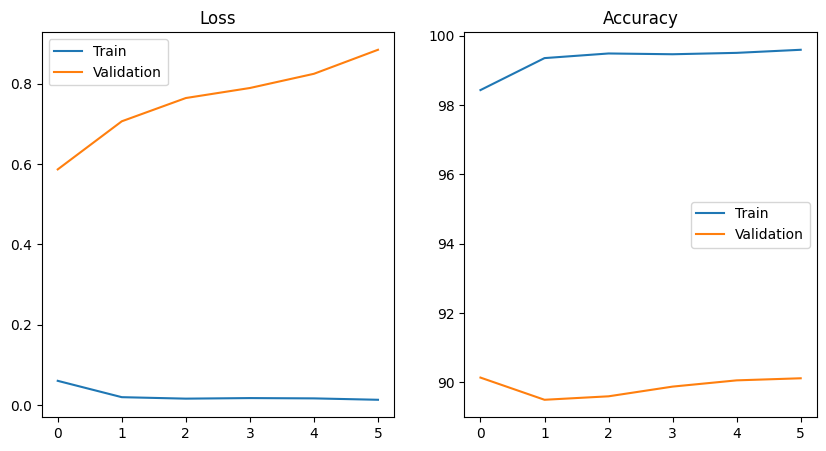

In [22]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [23]:
# Save the trained model
torch.save(mlp_model.state_dict(), 'mlp_model_compress.pth')

In [23]:
## test 
test_total = 0
test_correct = 0 

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_features_batch = model.features(test_inputs)
        test_features_batch = test_features_batch.view(-1, 2048, 1, 1)
        test_x = test_features_batch[:, feat.long(), :, :]

        test_outputs = mlp_model(test_x)

        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

# Calculate validation accuracy and loss
test_accuracy = 100 * test_correct / test_total
print("test_accuracy : " , test_accuracy )

test_accuracy :  89.96


In [24]:
# CSI and SI of last layer after Compression for train
features = []
labels = []

with torch.no_grad():
    for inputs, targets  in tqdm(train_loader_SI):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')
        # Forward pass through the model.features
        features_batch = model.features(inputs)
        features_batch = features_batch.view(-1, 2048, 1, 1)
        features_batch = features_batch[:, feat.long(), :, :]
        
        features.append(features_batch)
        labels.append(targets)
        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()
        
# Stack and reshape the extracted features
features = torch.cat(features)
features = features.view(features.size(0), -1)
labels = torch.cat(labels)   

labels=labels.unsqueeze(1)  # Make it a 2D tensor

100%|██████████| 40/40 [00:00<00:00, 51.97it/s]


In [25]:
instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)

si_last_compress = instance_disturbance.si()
csi_last_compress = instance_disturbance.center_si()

print("train_si_last_compress: ", si_last_compress)
print("Train_csi_last_compress: ", csi_last_compress)


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 1119.08it/s]

train_si_last_compress:  0.9682
Train_csi_last_compress:  0.9037999510765076


In [26]:
# CSI and SI of last layer after Compression for test
features = []
labels = []

with torch.no_grad():
    for inputs, targets  in tqdm(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda:1')
        # Forward pass through the model.features
        features_batch = model.features(inputs)
        features_batch = features_batch.view(-1, 2048, 1, 1)
        features_batch = features_batch[:, feat.long(), :, :]
        
        features.append(features_batch)
        labels.append(targets)
        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()
        
# Stack and reshape the extracted features
features = torch.cat(features)
features = features.view(features.size(0), -1)
labels = torch.cat(labels)   

labels=labels.unsqueeze(1)  # Make it a 2D tensor

100%|██████████| 79/79 [00:01<00:00, 76.25it/s] 


In [27]:
instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)

si_last_compress = instance_disturbance.si()
csi_last_compress = instance_disturbance.center_si()

print("test_si_last_compress: ", si_last_compress)
print("test_csi_last_compress: ", csi_last_compress)


Data has been normalized


Calculating Class Centers: 100%|██████████| 10/10 [00:00<00:00, 8111.20it/s]

test_si_last_compress:  0.8541
test_csi_last_compress:  0.8307999968528748


# calculate model parametres

In [28]:
# no hidden layer

total_parameters = sum(p.numel() for p in model.features.parameters()) + sum(p.numel() for p in mlp_model.parameters())

print("Total number of parameters:", total_parameters)

Total number of parameters: 26100042
